# Importing libraries


In [494]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer  # enables IterativeImputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, mean_absolute_error, mean_squared_error, r2_score, classification_report, f1_score

# Loading the Dataset

In [472]:
trainDF = pd.read_csv('./data/train.csv')
testDF = pd.read_csv('./data/test.csv')

# Check train info

In [473]:
trainDF.info(), trainDF.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


(None,
        PassengerId    Survived      Pclass         Age       SibSp  \
 count   891.000000  891.000000  891.000000  714.000000  891.000000   
 mean    446.000000    0.383838    2.308642   29.699118    0.523008   
 std     257.353842    0.486592    0.836071   14.526497    1.102743   
 min       1.000000    0.000000    1.000000    0.420000    0.000000   
 25%     223.500000    0.000000    2.000000   20.125000    0.000000   
 50%     446.000000    0.000000    3.000000   28.000000    0.000000   
 75%     668.500000    1.000000    3.000000   38.000000    1.000000   
 max     891.000000    1.000000    3.000000   80.000000    8.000000   
 
             Parch        Fare  
 count  891.000000  891.000000  
 mean     0.381594   32.204208  
 std      0.806057   49.693429  
 min      0.000000    0.000000  
 25%      0.000000    7.910400  
 50%      0.000000   14.454200  
 75%      0.000000   31.000000  
 max      6.000000  512.329200  )

# Check Null Entries Only for the Training Features

In [474]:
features = ['Age', 'Pclass', 'Sex', 'Embarked']
trainDF[features].isnull().sum()

Age         177
Pclass        0
Sex           0
Embarked      2
dtype: int64

we have a lot of null entries in the Age column, we can fill it with the mean of the column or predictive imputation


# Visualizing the Data

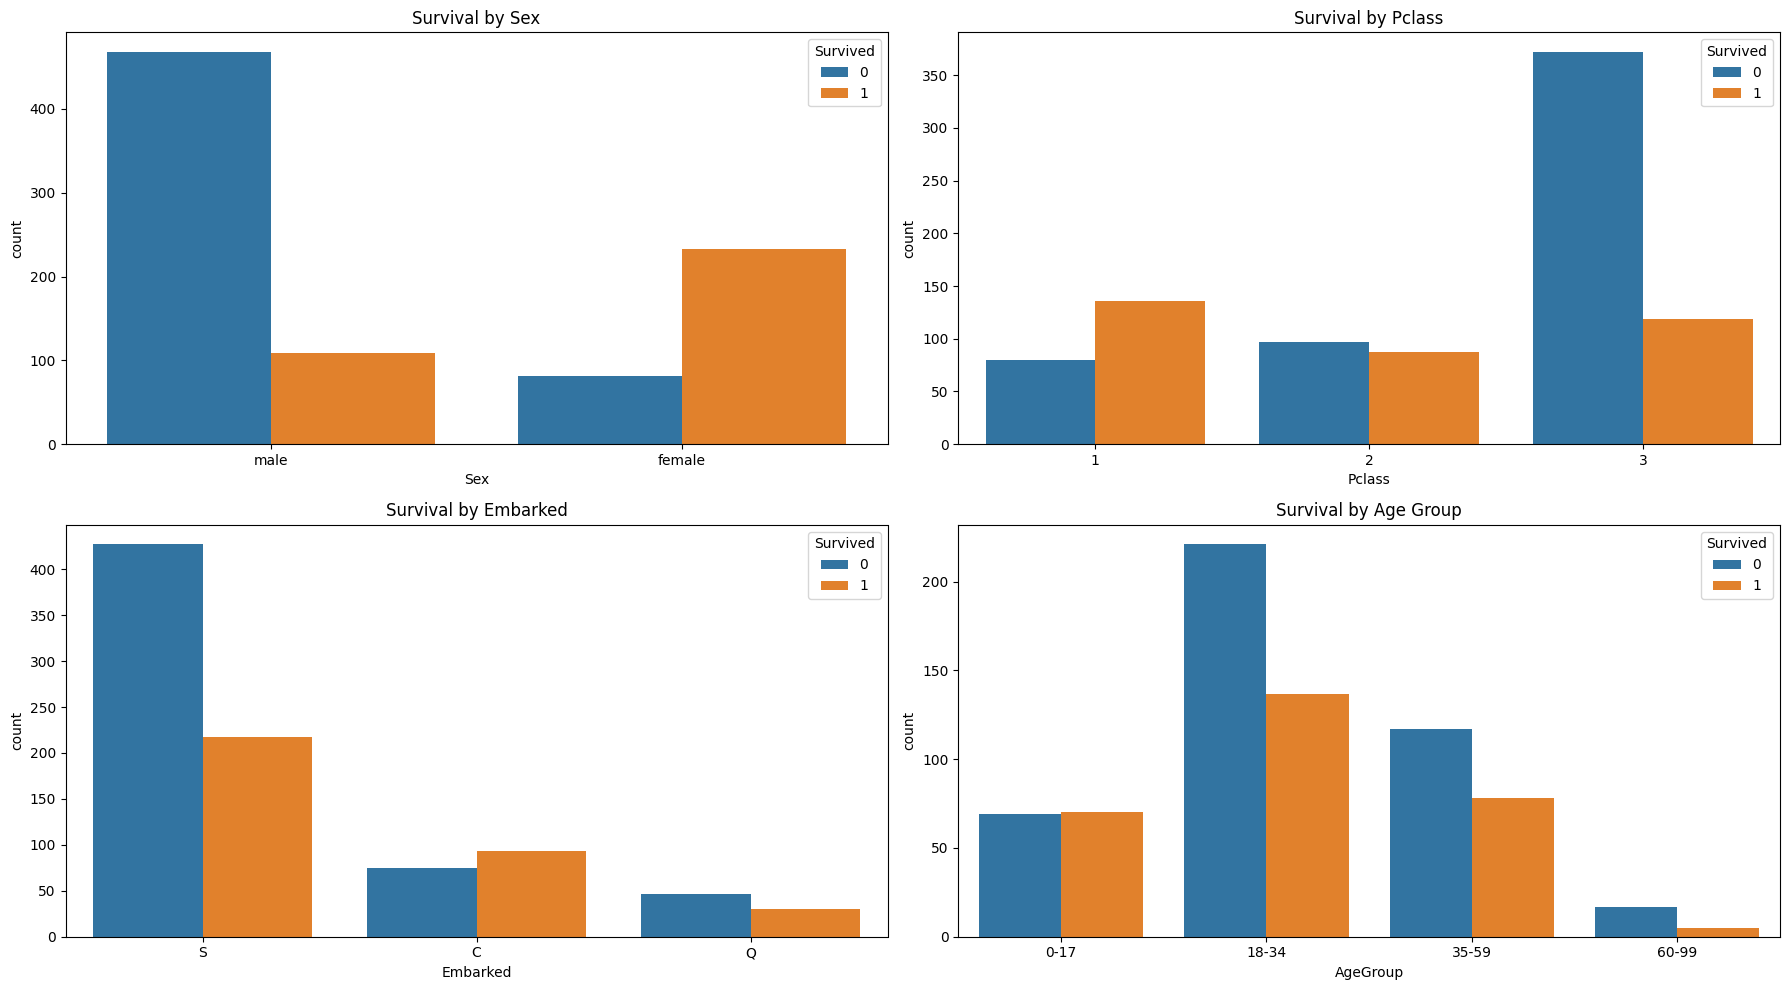

In [475]:
fig, axes = plt.subplots(2, 2, figsize=(18, 10))  # 2 rows, 3 columns
axes = axes.flatten()

# Plot 1: Survival by Sex
sns.countplot(x='Sex', hue='Survived', data=trainDF, ax=axes[0])
axes[0].set_title("Survival by Sex")

# Plot 2: Survival by Pclass
sns.countplot(x='Pclass', hue='Survived', data=trainDF, ax=axes[1])
axes[1].set_title("Survival by Pclass")

# Plot 3: Survival by Embarked
sns.countplot(x='Embarked', hue='Survived', data=trainDF, ax=axes[2])
axes[2].set_title("Survival by Embarked")

# Plot 4: Survival by AgeGroup
trainDF['AgeGroup'] = pd.cut(
    trainDF['Age'],
    bins=[0, 18, 35, 60, 100],  # broad groups
    labels=['0-17', '18-34', '35-59', '60-99']
)
sns.countplot(x='AgeGroup', hue='Survived', data=trainDF, ax=axes[3])
axes[3].set_title("Survival by Age Group")

plt.tight_layout()
plt.show()


# Create X (all columns except target) and Y (target column)


In [476]:
trainX = trainDF.drop(columns=['Survived'])
trainy = trainDF['Survived']

X_train, X_test, y_train, y_test = train_test_split(trainX, trainy, test_size=0.2, random_state=42)

X_train[features].isnull().sum(), X_test[features].isnull().sum()


(Age         140
 Pclass        0
 Sex           0
 Embarked      2
 dtype: int64,
 Age         37
 Pclass       0
 Sex          0
 Embarked     0
 dtype: int64)

# Seperate numerical and categorical features

In [477]:
# Pclass 1,2,3
# sex male or female
# Embarked C = Cherbourg, Q = Queenstown, S = Southampton
numericalFeatures = ['Age', 'Pclass']
categoricalFeatures = ['Sex', 'Embarked']

# Prepare the pipeline

In [478]:
categoricalTransformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # fill missing with mode
    ('onehot', OneHotEncoder(handle_unknown='ignore'))     # one-hot encode
])

numericalTransformer = Pipeline(steps=[
    ('imputer', IterativeImputer(random_state=42))  # predictive imputation
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numericalTransformer, numericalFeatures),
        ('cat', categoricalTransformer, categoricalFeatures)
    ]
)

# Prepare the models

In [479]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

np.random.seed(42)

models = {
      'RandomForest': RandomForestClassifier(random_state=42),
      'LogisticRegression': LogisticRegression(random_state=42),
      'XGBoost': XGBClassifier(random_state=42)
}

results = {}
predicts = {}

# Train The models

In [480]:
for name, model in models.items():
   modelPipeline = Pipeline(steps=[("preprocessor", preprocessor),
                                    ("model", model)])
   print(f"Fitting {name}...")

   modelPipeline.fit(X_train, y_train)

   y_pred = modelPipeline.predict(X_test)
   predicts[name] = y_pred
   
   results[name] = modelPipeline.score(X_test, y_test)

   scores = cross_val_score(modelPipeline, X_train, y_train, cv=5, scoring='accuracy')
   print(f"{name} Average CV Accuracy: {np.mean(scores):.4f}")

Fitting RandomForest...
RandomForest Average CV Accuracy: 0.7963
Fitting LogisticRegression...
LogisticRegression Average CV Accuracy: 0.7837
Fitting XGBoost...
XGBoost Average CV Accuracy: 0.8020


# Printing the Results

(<BarContainer object of 3 artists>,
 {'RandomForest': 0.770949720670391,
  'LogisticRegression': 0.7988826815642458,
  'XGBoost': 0.8100558659217877})

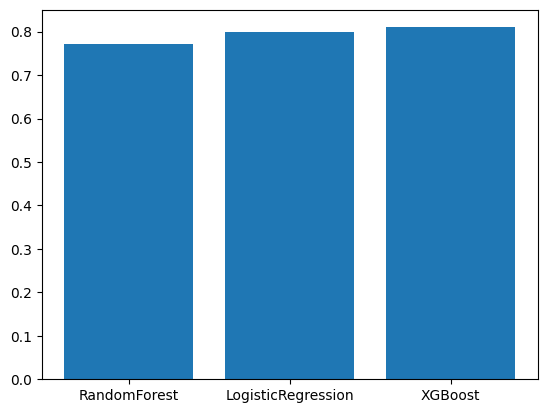

In [481]:
resultsDF = pd.DataFrame(results.values(), 
                          results.keys(), 
                          columns=["accuracy"])

plt.bar(resultsDF.index, resultsDF['accuracy']), results

# Metrics

1- mean squared error

In [482]:
for name, y_pred in predicts.items():
    mse = mean_squared_error(y_test, y_pred)
    print(f"{name} Mean Squared Error: {mse:.4f}")

RandomForest Mean Squared Error: 0.2291
LogisticRegression Mean Squared Error: 0.2011
XGBoost Mean Squared Error: 0.1899


2- mean absolute error

In [483]:
for name, y_pred in predicts.items():
   mae = mean_absolute_error(y_test, y_pred)
   print(f"{name} Mean Absolute Error: {mae:.4f}")

RandomForest Mean Absolute Error: 0.2291
LogisticRegression Mean Absolute Error: 0.2011
XGBoost Mean Absolute Error: 0.1899


3- r2 score

In [484]:
for name, y_pred in predicts.items():
   r2 = r2_score(y_test, y_pred)
   print(f"{name} Mean Absolute Error: {r2:.4f}")

RandomForest Mean Absolute Error: 0.0555
LogisticRegression Mean Absolute Error: 0.1707
XGBoost Mean Absolute Error: 0.2167


4- accuracy score

In [485]:
for name, y_pred in predicts.items():
   acc = accuracy_score(y_test, y_pred)
   print(f"{name} Accuracy: {acc:.4f}")

RandomForest Accuracy: 0.7709
LogisticRegression Accuracy: 0.7989
XGBoost Accuracy: 0.8101


5- precision score

In [486]:
for name, y_pred in predicts.items():
   precision = precision_score(y_test, y_pred)
   print(f"{name} Precision: {precision:.4f}")

RandomForest Precision: 0.7260
LogisticRegression Precision: 0.7639
XGBoost Precision: 0.7857


6- Recall score

In [487]:
for name, y_pred in predicts.items():
   recall = recall_score(y_test, y_pred)
   print(f"{name} Recall: {recall:.4f}")

RandomForest Recall: 0.7162
LogisticRegression Recall: 0.7432
XGBoost Recall: 0.7432


7- Confusion Matrix

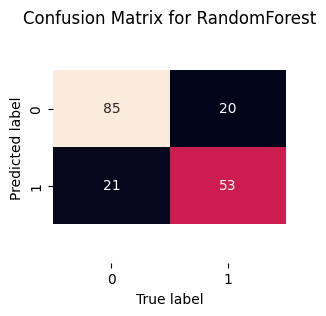

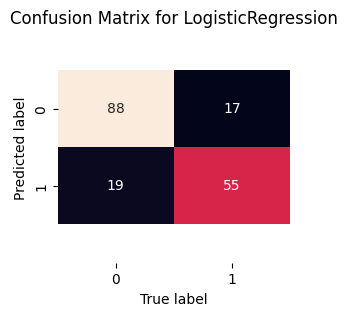

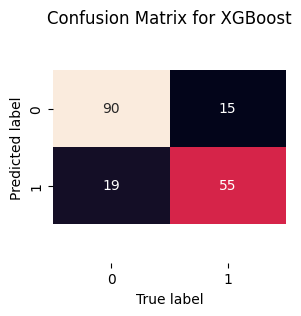

In [488]:
def plot_conf_mat(y_test, y_preds):
    """
    Plots a confusion matrix using Seaborn's heatmap().
    """
    fig, ax = plt.subplots(figsize=(3, 3))
    ax = sns.heatmap(confusion_matrix(y_test, y_preds),
                     annot=True, # Annotate the boxes
                     cbar=False)
    plt.xlabel("True label")
    plt.ylabel("Predicted label")
    
    # Fix the broken annotations (this happened in Matplotlib 3.1.1)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    
for name, y_pred in predicts.items():
      plot_conf_mat(y_test, y_pred)
      plt.title(f"Confusion Matrix for {name}")
      plt.show()

8- f1 score

In [493]:
for name, y_pred in predicts.items():
   f1 = f1_score(y_test, y_pred)
   print(f"F1 score: {f1:.2f}")

F1 score: 0.72
F1 score: 0.75
F1 score: 0.76


Finally, classification report

In [491]:
for name, y_pred in predicts.items():
   report = classification_report(y_test, y_pred)
   print(f"Classification Report for {name}:\n{report}")
   print()
   

Classification Report for RandomForest:
              precision    recall  f1-score   support

           0       0.80      0.81      0.81       105
           1       0.73      0.72      0.72        74

    accuracy                           0.77       179
   macro avg       0.76      0.76      0.76       179
weighted avg       0.77      0.77      0.77       179


Classification Report for LogisticRegression:
              precision    recall  f1-score   support

           0       0.82      0.84      0.83       105
           1       0.76      0.74      0.75        74

    accuracy                           0.80       179
   macro avg       0.79      0.79      0.79       179
weighted avg       0.80      0.80      0.80       179


Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       0.83      0.86      0.84       105
           1       0.79      0.74      0.76        74

    accuracy                           0.81       179
   ma

# Hyperparameter Tuning

1- Logistic Regression

In [ ]:
paramGridLG = {
    'model__C': np.logspace(-4, 4, 20),  
    'model__solver': ['liblinear', 'lbfgs']
}

logRegPipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", LogisticRegression(random_state=42, max_iter=1000))
])

gridSearchLG = GridSearchCV(logRegPipe, paramGridLG, cv=5, scoring='accuracy')

gridSearchLG.fit(X_train, y_train)

print("Best Parameters:", gridSearchLG.best_params_)
print("Best Cross-Validation Accuracy:", gridSearchLG.best_score_)

Best Parameters: {'model__C': np.float64(0.012742749857031334), 'model__solver': 'liblinear'}
Best Cross-Validation Accuracy: 0.8005515611149414


2- Random Forest

In [502]:
paramGridRF = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [None, 5, 10],
    'model__min_samples_split': [2, 5, 10]
}

ranForPipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", RandomForestClassifier(random_state=42))
])

gridSearchRF = GridSearchCV(ranForPipe, paramGridRF, cv=5, scoring='accuracy')
gridSearchRF.fit(X_train, y_train)

print("Best Parameters:", gridSearchRF.best_params_)
print("Best Cross-Validation Accuracy:", gridSearchRF.best_score_)

Best Parameters: {'model__max_depth': 5, 'model__min_samples_split': 2, 'model__n_estimators': 100}
Best Cross-Validation Accuracy: 0.8300502314586822


3- XGBoost 

In [505]:
paramGridXGB = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [3, 5, 7],
    'model__learning_rate': [0.01, 0.1, 0.3]
}

xgpPipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", XGBClassifier(random_state=42, eval_metric='logloss'))
])

gridSearchXGB = GridSearchCV(xgpPipe, paramGridXGB, cv=5, scoring='accuracy')
gridSearchXGB.fit(X_train, y_train)

print("Best Parameters:", gridSearchXGB.best_params_)
print("Best Cross-Validation Accuracy:", gridSearchXGB.best_score_)

Best Parameters: {'model__learning_rate': 0.01, 'model__max_depth': 5, 'model__n_estimators': 100}
Best Cross-Validation Accuracy: 0.8300600807643062


we found the XGBoost to be the best one, so we will predict the test set with it

# Prediction of the test set with XGBoost

In [ ]:
finalModelParams = gridSearchXGB.best_params_
finalModel = XGBClassifier(**finalModelParams, random_state=42, eval_metric='logloss')
finalPipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", finalModel)
])

# Maximizing Learning
finalPipe.fit(X_train, y_train)

finalPrediction = finalPipe.predict(testDF[features])

submission = pd.DataFrame({
    "PassengerId": testDF["PassengerId"],
    "Name": testDF["Name"],
    "Age": testDF["Age"],
    "Sex": testDF["Sex"],
    "Pclass": testDF["Pclass"],
    "Embarked": testDF["Embarked"],
    "Survived": finalPrediction
})
submission.to_csv("./data/titanic_predictions.csv", index=False)

c:\Users\HP\Desktop\aiEngineer\testenv\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:53:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "model__learning_rate", "model__max_depth", "model__n_estimators" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [513]:
submission.head(10)

,PassengerId,Name,Age,Sex,Pclass,Embarked,Survived
0,892,"Kelly, Mr. James",34.5,male,3,Q,0
1,893,"Wilkes, Mrs. James (Ellen Needs)",47.0,female,3,S,0
2,894,"Myles, Mr. Thomas Francis",62.0,male,2,Q,0
3,895,"Wirz, Mr. Albert",27.0,male,3,S,1
4,896,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",22.0,female,3,S,1
5,897,"Svensson, Mr. Johan Cervin",14.0,male,3,S,0
6,898,"Connolly, Miss. Kate",30.0,female,3,Q,1
7,899,"Caldwell, Mr. Albert Francis",26.0,male,2,S,0
8,900,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",18.0,female,3,C,0
9,901,"Davies, Mr. John Samuel",21.0,male,3,S,0
